#Single-photon Classification

##Paper figures (see SinglePhotonToyExample.ipynb for the content of Fig. 1) 

In [0]:
from colorsys import hls_to_rgb
from google.colab import files
import math
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import cm
import numpy as np
from scipy.linalg import expm
import tensorflow.compat.v2 as tf
import tensorflow.compat.v2.keras as keras

In [0]:
np.set_printoptions(linewidth=200)
rng = np.random.RandomState(seed=2)

# The computationally expensive part is exponentiating the Lie algebra element
# to obtain the SU(790) "de-mixing" basis transformation.
# This is then applied to all items in the batch uniformly. Since the rest
# of the computation is easy, this suggests we should go with large batch sizes.
BATCH_SIZE = 8192
NUM_CLASSES = 10
XDIM = 28
XYDIM = 784
XYDIM_EXT = 790

DATASET_MNIST = tf.keras.datasets.mnist
DATASET_FASHION = tf.keras.datasets.fashion_mnist

In [0]:
def UploadFile(user_message):
  print(user_message)
  uploaded_files = None
  while True:
    uploaded_files = files.upload()
    if (len(uploaded_files) > 2 or
        not all(x.endswith('.npy') for x in uploaded_files.keys())):
      print('Please only upload exactly one .npy file')
      continue
    try:
      uploaded_h0 = np.load(list(uploaded_files)[0]).astype(np.float64)
      if uploaded_h0.shape != (XYDIM_EXT, XYDIM_EXT):
        print('Matrix size mismatch.')
        continue
      break
    except Exception as e:
      print('Parse error:', e)
  return uploaded_h0

In [7]:
# Upload trained models to visualize confusion matrixes and projectors.
# for fashion_mnist use fashion_mnist_trained_U790.npy
# for mnist use mnist_trained_U790.npy

mnist_h0 = UploadFile("Upload model for MNIST dataset.")
fashion_mnist_h0 = UploadFile("Upload model for Fashion-MNIST dataset.")

Upload model for MNIST dataset.


Saving mnist_trained_U790.npy to mnist_trained_U790 (4).npy
Upload model for Fashion-MNIST dataset.


Saving fashion_mnist_trained_U790.npy to fashion_mnist_trained_U790 (2).npy


In [0]:
def ReadSets(dataset, num_classes):
  (x_train255, y_train), (x_test255, y_test) = dataset.load_data()
  x_train, x_test = (x_train255 / 255.0), (x_test255 / 255.0)
  y_train_cat = keras.utils.to_categorical(y_train, num_classes)
  y_test_cat = keras.utils.to_categorical(y_test, num_classes)
  return x_train, y_train_cat, x_test, y_test_cat


In [0]:

def MostLikelyCategory(x_train, y_train_cat):
  # "Classical baseline" performance:
  # If a pixel arrives at (row, col), we need to know the most likely digit,
  # with probabilities as observed on the training set.
  x_train_intensity_per_cat = np.einsum('byx,bc->yxc', x_train, y_train_cat)
  
  # Trick: We add a tiny randomized-for-random-tie-breaking 'epsilon'
  # to the brightnesses that only changes results for pixels that were
  # dark in every single training example.
  p_class_given_pixel = keras.utils.to_categorical(
    x_train_intensity_per_cat.argmax(axis=2))
  x_train_most_likely_pixel_cat = (x_train_intensity_per_cat +
    rng.uniform(low=0, high=1e-100, size=(28, 28, 10))).argmax(axis=2)
  x_train_prob = x_train_intensity_per_cat.max(axis=2)
  return (x_train_most_likely_pixel_cat, x_train_prob)

In [0]:
def Confusion(x_test, y_test_cat, x_train_most_likely_pixel_cat):
  scale_sample = np.einsum('byx->b', x_test)
  p_pixel_given_class = np.einsum('byx,bc->yxc',
                                  x_test / scale_sample.reshape([-1, 1, 1]),
                                  y_test_cat) / x_test.shape[0]
  p_est_class_given_pixel = keras.utils.to_categorical(
      x_train_most_likely_pixel_cat)
  p_confusion = np.einsum('yxc,yxd->dc',
                          p_est_class_given_pixel,
                          p_pixel_given_class)
  return p_confusion

In [0]:
def quantum_states_from_xs(xs):
  amplitudes = np.sqrt(
      xs / np.einsum('byx->b', xs)[:, np.newaxis, np.newaxis])
  return np.pad(amplitudes.reshape(xs.shape[0], -1),
                  ((0, 0), (0, XYDIM_EXT - XYDIM)),
                   'constant', constant_values=(0, 0)) 

In [0]:
def parameters_to_unitary(h0):
  h0_T = np.transpose(h0)
  ih = np.zeros_like(h0, dtype=np.complex128)
  ih.real = h0 - h0_T
  ih.imag = h0 + h0_T
  u = expm(ih)
  return u

In [0]:
def ConfusionOurs(x_test, y_test_cat, h0):
  u = parameters_to_unitary(h0)
  xq_test = quantum_states_from_xs(x_test)
  u_psi = np.reshape(
      np.einsum('bp,qp->bq', xq_test.astype(np.complex128), u),
      (-1, NUM_CLASSES, XYDIM_EXT // NUM_CLASSES))
  u_psi_r = np.real(u_psi)
  u_psi_i = np.imag(u_psi)
  probs = np.einsum('bcs->bc', np.square(u_psi_r) + np.square(u_psi_i))
  p_confusion = np.einsum('bc,bd->dc', probs, y_test_cat) / x_test.shape[0]
  return p_confusion

In [0]:
def PlotPixelMap(x_most_likely_pixel_cat, prob, filename, xlabel=None):
  fig = plt.figure(figsize=(6, 6))
  n, m = x_most_likely_pixel_cat.shape
  plt.axis([-1, n, m, -1])
  #plt.imshow(prob)
  font0 = FontProperties()
  font1 = font0.copy()
  font1.set_size('xx-small')
  plt.rcParams['axes.facecolor'] = 'white'
  for (r, c), value in np.ndenumerate(x_most_likely_pixel_cat):
    if prob[r, c] > 0:
      plt.text(c, r, str(value), horizontalalignment='center',
               verticalalignment='center', fontproperties=font1)
  #plt.axis('off')
  ax = plt.gca()
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.xticks([])
  plt.yticks([])
  if xlabel:
    ax.set_xlabel(xlabel)
  plt.savefig(filename, bbox_inches='tight')
  files.download(filename)

In [0]:
def PlotConfusionMatrix(p_confusion, filename, xlabel=None):
  fig = plt.figure(figsize=(6, 6))
  font0 = FontProperties()
  font1 = font0.copy()
  font1.set_size('xx-small')
  plt.rcParams['axes.facecolor'] = 'white'
  ax = fig.gca()
  ax.grid(False)
  #plt.xticks([])
  #plt.yticks([])
  ax.set_xticks(range(0, 10))
  ax.set_yticks(range(0, 10))
  ax.set_ylabel('True')
  ax.set_title('Predicted')
  if xlabel:
    ax.set_xlabel(xlabel)
  im = plt.imshow(p_confusion, interpolation='none', norm=plt.Normalize(vmin=0, vmax=0.06))
  fig.colorbar(im, ax=ax, ticks=[0, 0.012, 0.024, 0.036, 0.048, 0.060], shrink=0.8)
  plt.savefig(filename, bbox_inches='tight')
  files.download(filename)

In [0]:
def ComputeProjectors(h0):
  cat_projectors = [np.diag(
        np.einsum('c,x->cx',
                  np.array([c == n for n in range(10)]),
                  np.ones(XYDIM_EXT // NUM_CLASSES)).reshape(-1))
              for c in range(NUM_CLASSES)]
  u = parameters_to_unitary(h0)
  u_inv = u.T.conj()
  projectors = np.stack([np.matmul(u_inv, np.matmul(cp, u))
    for cp in cat_projectors], axis=0)
  return projectors

In [0]:
def DecomposeSamples(h0, x_test, test_indices):
  projectors = ComputeProjectors(h0)
  xq_test = quantum_states_from_xs(x_test[test_indices, :, :])
  xq_decomposed = np.einsum('cyx,bx->bcy', projectors, xq_test)
  xq_decomposed_res = np.reshape(xq_decomposed[:, :, :XYDIM], (-1, NUM_CLASSES, XYDIM // XDIM, XDIM))
  return xq_decomposed_res


In [0]:
def ComplexToRGB(sample, mag_scale):
  height, width = sample.shape
  mag = np.absolute(sample) * mag_scale
  h = (np.angle(sample) + math.pi) / (2 * math.pi) + 0.5
  l = 1.0 - 1.0/(1.0 + mag ** 0.8)
  s = 0.8 * np.ones((height, width), dtype=np.float64)
  r, g, b = np.vectorize(hls_to_rgb)(h, l, s)
  rgb = np.stack((r, g, b), axis=2)
  return rgb

#Test Complex Visualization

To visualize complex probability amplitudes, we use brihgntess for magnitude and hue for phase. This is visualize in the following figure. 


Text(0.5,0,'Phase')

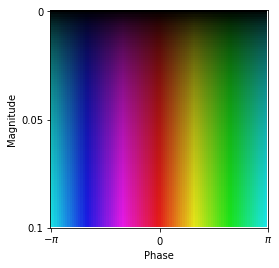

In [19]:
ex_g = np.zeros((100, 100), np.complex)
eg_g_magnitude = np.reshape(np.linspace(0, 0.1, 100, endpoint=True), (-1, 1))
ex_g.real = eg_g_magnitude * np.cos([np.linspace(-math.pi, math.pi, 100)])
ex_g.imag = eg_g_magnitude * np.sin([np.linspace(-math.pi, math.pi, 100)])
ex_g_rgb = ComplexToRGB(ex_g, 10.0)
fig = plt.figure(figsize=(4, 4))
plt.imshow(ex_g_rgb)
ax = fig.gca()
ax.grid(False)
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([0, 0.05, 0.1])
ax.set_xticks([0, 50, 100])
ax.set_xticklabels(['$-\pi$', '$0$', '$\pi$'])
ax.set_ylabel('Magnitude')
ax.set_xlabel('Phase')


In [0]:
def PlotSamples(samples, dec_samples, filename, figsize=(16, 8), xlabel=None):
  num_images, num_classes, height, width = dec_samples.shape
  fig, axs = plt.subplots(num_images, 12, figsize=figsize,
                          gridspec_kw={'width_ratios': [1] * 11 + [0.25],
                                       'height_ratios': [1] * num_images})
  norm = cm.colors.Normalize(vmax=1.03, vmin=0)
  norm_dec = cm.colors.Normalize(vmax=0.01, vmin=0)
  font0 = FontProperties()
  font1 = font0.copy()
  font1.set_size('xx-small')
  bar = np.zeros((7, 28), np.complex)
  bar_magnitude = 0.07
  bar.real = bar_magnitude * np.cos([np.linspace(-math.pi, math.pi, 28)])
  bar.imag = bar_magnitude * np.sin([np.linspace(-math.pi, math.pi, 28)])
  bar_rgb = ComplexToRGB(bar.T, 6.0)
  for im_index in range(num_images):
    ax = axs[im_index, 0]
    ax.imshow(samples[im_index, :, :], cmap=plt.get_cmap('gray'), norm=norm, interpolation='nearest')
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    if not im_index:
      ax.set_title('Sample')
    for c_index in range(0, num_classes):
      ax = axs[im_index, c_index + 1]
      rgb = ComplexToRGB(dec_samples[im_index, c_index, :, :], 6)
      ax.imshow(rgb, interpolation='nearest')  # , cmap=plt.get_cmap('gray'), norm=norm_dec)
      if not im_index: 
        ax.set_title('c = %d' % c_index)
      ax.grid(False)
      ax.set_yticklabels([])
      ax.set_xticklabels([])
      ax.set_xticks([])
      ax.set_yticks([])
    ax = axs[im_index, num_classes + 1]
    ax.imshow(bar_rgb)
    ax.grid(False)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_yticklabels(['$-\pi$', '$0$', '$\pi$'])
    ax.set_yticks([0, 14, 28])
    ax.set_xticklabels([])
    ax.set_xticks([])
  plt.subplots_adjust(wspace=0.03, hspace=0.01)
  if xlabel:
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='red', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.xlabel(xlabel)
    plt.gca().xaxis.set_label_coords(0.5, -0.08)
  plt.savefig(filename, bbox_inches='tight')
  files.download(filename)

#Fashion MNIST

4431872/4422102 [==============================] - 0s 0us/step


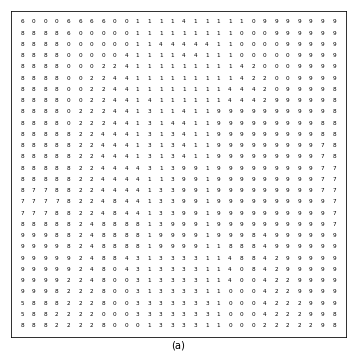

In [46]:
x_train, y_train_cat, x_test, y_test_cat = ReadSets(DATASET_FASHION, NUM_CLASSES)
x_train_most_likely_pixel_cat, x_train_prob = MostLikelyCategory(x_train, y_train_cat)
PlotPixelMap(x_train_most_likely_pixel_cat, x_train_prob, 'fashion_map.png', '(a)')

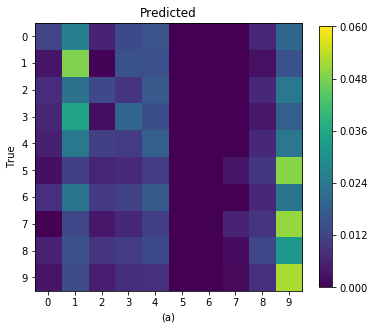

In [47]:
p_confusion_test = Confusion(x_test, y_test_cat, x_train_most_likely_pixel_cat)
PlotConfusionMatrix(p_confusion_test, 'fashion_mnist_confusion.png', '(a)')

In [48]:
print("Accuray baseline ", np.trace(p_confusion_test))

('Accuray baseline ', 0.18265235950808717)


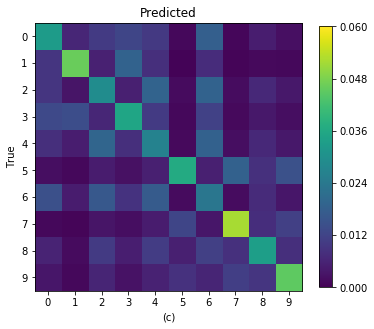

In [50]:
p_confusion_ours = ConfusionOurs(x_test, y_test_cat, fashion_mnist_h0)
PlotConfusionMatrix(p_confusion_ours, 'fashion_mnist_confusion_ours.png', '(c)')

In [51]:
print("Accuray ours ", np.trace(p_confusion_ours))

('Accuray ours ', 0.3616346100243441)


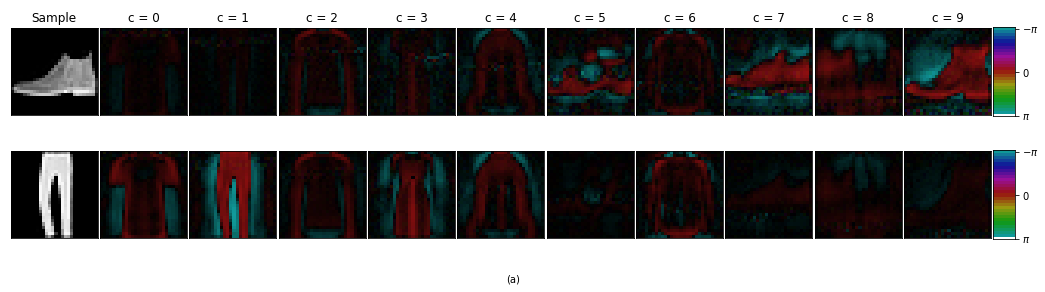

In [53]:
test_indices = [0, 2]
dec_samples = DecomposeSamples(fashion_mnist_h0, x_test, test_indices)
PlotSamples(x_test[test_indices, :, :], dec_samples, 'fashion_mnist_projection.png', figsize=(18, 1.5 * (len(test_indices) + 1)), xlabel='(a)')

##MNIST

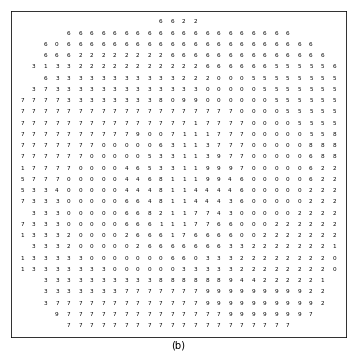

In [32]:
# Most likely class for each photon arrival location (figure 2(b).)

x_train, y_train_cat, x_test, y_test_cat = ReadSets(DATASET_MNIST, NUM_CLASSES)
x_train_most_likely_pixel_cat, x_train_prob = MostLikelyCategory(x_train, y_train_cat)
PlotPixelMap(x_train_most_likely_pixel_cat, x_train_prob, 'mnist_map.png', '(b)')

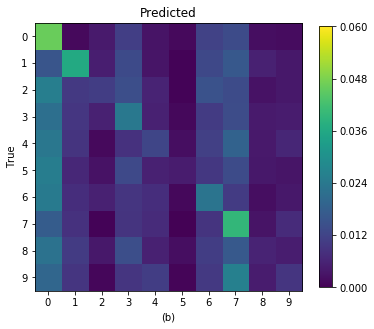

In [33]:
# Confusion matrix (figure 3(b).)

p_confusion_test = Confusion(x_test, y_test_cat, x_train_most_likely_pixel_cat)
PlotConfusionMatrix(p_confusion_test, 'mnist_confusion.png', '(b)')

In [34]:
print("Accuray baseline ", np.trace(p_confusion_test))

('Accuray baseline ', 0.21269599054501545)


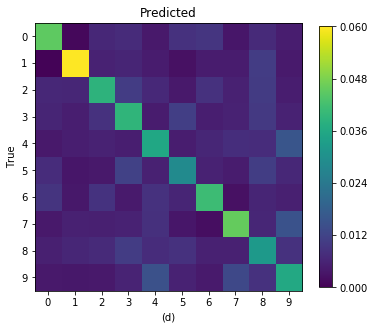

In [35]:
p_confusion_ours = ConfusionOurs(x_test, y_test_cat, mnist_h0)
PlotConfusionMatrix(p_confusion_ours, 'mnist_confusion_ours.png', '(d)')

In [36]:
print("Accuray ours ", np.trace(p_confusion_ours))

('Accuray ours ', 0.4129158414979361)


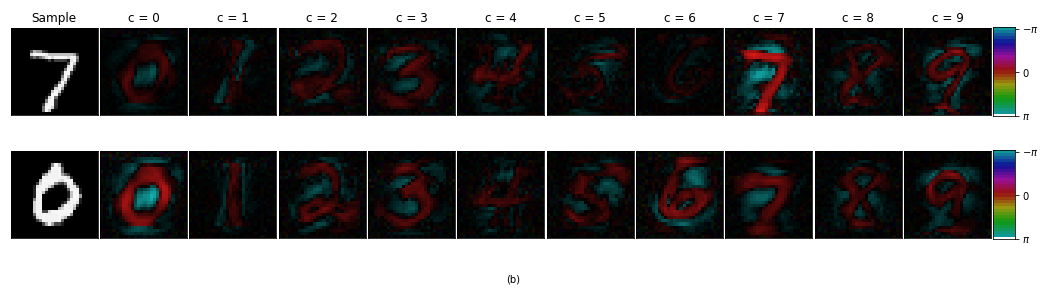

In [45]:
# Visualize decomposition of some test instances with respect to the set of
# projectors.

test_indices = [0, 3] # These are indexes used for the decomposition.
dec_samples = DecomposeSamples(mnist_h0, x_test, test_indices)
PlotSamples(x_test[test_indices, :, :], dec_samples, 'mnist_projection.png', figsize=(18, 1.5 * (len(test_indices) + 1)), xlabel='(b)')

#An example of factorization

Below, we give an example of a 'measurement' of an atom spin.

In [54]:
import numpy as np
import math
import scipy.linalg

# Initial psi atom.
atom_initial_up = np.array([1.0, 0.0])
atom_initial_down = np.array([0.0, 1.0])
c = np.sqrt([0.9, 0.1])
atom_initial = c[0] * atom_initial_up + c[1] * atom_initial_down
# Initial psi apparatus
apparatus_initial = np.array([0.0, 1.0, 0.0, 0.0])

# Initial joint psi atom-apparatus.
all_initial = np.einsum('a,A->aA', atom_initial, apparatus_initial).reshape(-1)
print("psi_all_initial = ", all_initial)

# We model the interaction between atom and apparatus with a rotation (this
# represents the solution of the Schroedinger equation modeling the
# interaction.)
rng = np.random.RandomState(seed=0)
gen0 = rng.normal(size=(8, 8))
gen = gen0 - gen0.T
rotation = scipy.linalg.expm(gen)

# Final state after the interaction.
all_final = np.dot(rotation, all_initial)

print("psi_all_final = ", all_final.round(3))

xstate = lambda atom, app: np.einsum('a,A->aA', atom, app).reshape(-1)
normalized = lambda v: v / (v*v).sum()**.5

# Apparatus state when spin up is observed.
apparatus_up = normalized(all_final[0:4])
# Apparatus state when spin down is observed.
apparatus_down = normalized(all_final[4:])
# Probability amplitudes of observing spin up or down
alpha = all_final[0] / apparatus_up[0]
beta = all_final[4] / apparatus_down[0]
print("Factorization of psi_all_final ",
      alpha * xstate([1.0, 0.0], apparatus_up) +
      beta * xstate([0.0, 1.0], apparatus_down))
print("apparatus_up ", apparatus_up)
print("apparatus_down ", apparatus_down)
 

('psi_all_initial = ', array([0.        , 0.9486833 , 0.        , 0.        , 0.        , 0.31622777, 0.        , 0.        ]))
('psi_all_final = ', array([ 0.434,  0.011, -0.452,  0.104,  0.528, -0.283,  0.266,  0.409]))
('Factorization of psi_all_final ', array([ 0.43440705,  0.01062998, -0.45171184,  0.10402607,  0.52768409, -0.28319551,  0.26581982,  0.40865894]))
('apparatus_up ', array([ 0.68371361,  0.01673054, -0.71094962,  0.16372671]))
('apparatus_down ', array([ 0.68334031, -0.36673251,  0.34423134,  0.52920514]))
